# Bulk Deconvolution Using AutoGeneS

### Using Van Galen et al scRNA-seq Reference with Zeng et al HSPC Subset Annotations on TCGA Data

## Import Libraries

In [25]:
import numpy as np
import scanpy as sc
import scipy as sci
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import autogenes as ag
from sklearn.svm import NuSVR
import pickle

import warnings
warnings.filterwarnings("ignore")

## Reading in the inputs

### The Reference Dataset

Raw data was taken from the Van Galen et al paper (GSE116256), complied into a single AnnData file. 

Annotations were used from the Zeng et al paper (https://github.com/andygxzeng/AMLHierarchies), which labels LSPC subpopulations in this data.

In [2]:
#read single-cell data
file = './data/vgalen_adata.h5ad'
adata = sc.read_h5ad(file)
adata

AnnData object with n_obs × n_vars = 41249 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'batch', 'Zeng_CellType'

### The Bulk Datasets

Bulk datasets were downloaded from the TCGA (TARGET/BeatAML Studies), counts are raw.

In [3]:
path = './bulks/'
data_bulk_raw = pd.read_csv(path + 'AML_ETO_sample_counts.csv', index_col=0)
data_bulk_raw.head()

,TARGET-20-PASHYZ-09A-01R,TARGET-20-PANLIZ-09A-01R,TARGET-20-PASBPW-09A-02R,TARGET-20-PASXYG-04A-01R,TARGET-20-PATDHA-09A-01R,TARGET-20-PANNHB-09A-03R,TARGET-20-PANVGP-03A-04R,TARGET-20-PASPKE-09A-01R,TARGET-20-PARUUB-09A-01R,TARGET-20-PANLIZ-09A-03R,...,BA3270R,BA2054R,BA3353R,BA3413R,BA3036R,BA3335R,BA2449R,BA2172R,BA2526R,BA2789R
TSPAN6,4,11,77,8,1,9,7,2,0,7,...,8,24,26,1,20,266,2,64,1,1
TNMD,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
DPM1,702,1112,1823,1018,3380,2623,3073,435,389,2477,...,1882,1311,1955,1408,943,1557,2202,1211,1378,1261
SCYL3,355,341,459,841,371,366,234,102,134,383,...,1617,651,1491,959,1191,937,372,517,395,1536
C1orf112,662,230,3022,645,311,1127,512,27,158,308,...,806,558,1284,636,361,274,424,346,109,886


# Preprocessing Single-Cell data

In [4]:
adata.layers["counts"] = adata.X
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', layer='counts', n_top_genes=4000, batch_key='batch')

adata_proc = adata[:, adata.var[adata.var['highly_variable']==True].index]
adata_proc

View of AnnData object with n_obs × n_vars = 41249 × 4000
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'batch', 'Zeng_CellType'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

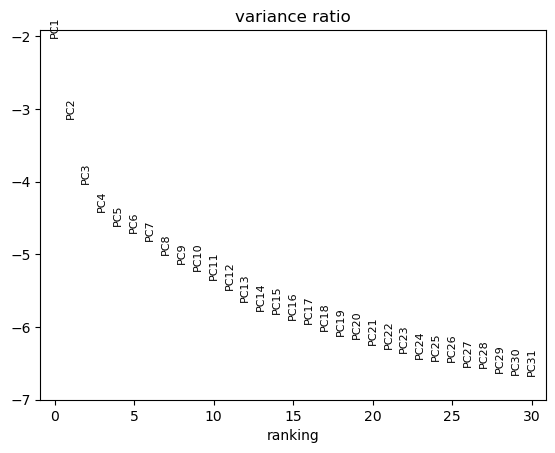

In [5]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

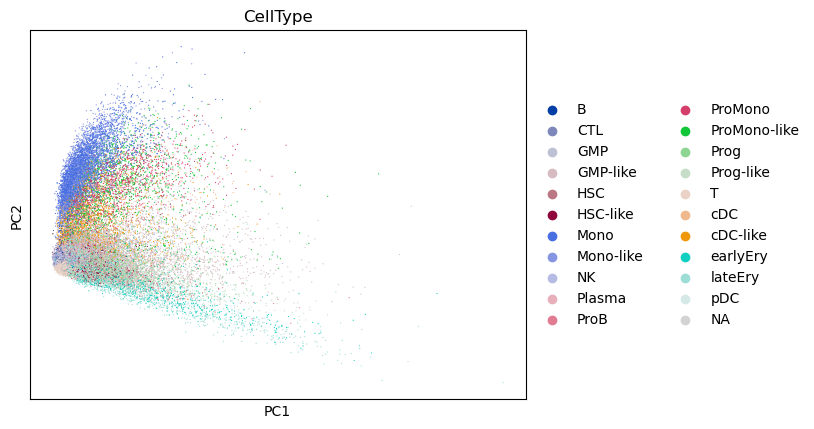

In [6]:
sc.pl.pca_scatter(adata, color='CellType')

In [7]:
clusters = list(adata.obs["CellType"].unique())
clusters = [x for x in clusters if str(x) != 'nan']
clusters = np.array(clusters)

sc_mean = pd.DataFrame(index=adata_proc.var_names,columns=clusters)
for cluster in clusters:
    cells = list(adata_proc[adata_proc.obs['CellType'] == cluster].obs.index)
    sc_part = adata_proc[cells,:].X.T
    sc_mean[cluster] = pd.DataFrame(np.mean(sc_part,axis=1),index=adata_proc.var_names)
    
centroids_sc_hv = sc_mean
centroids_sc_hv.shape

(4000, 21)

# AutoGeneS

### Optimization

In [8]:
ag.init(centroids_sc_hv.T)
ag.optimize(ngen=5000,seed=0,nfeatures=400,mode='fixed',offspring_size=100,verbose=False)

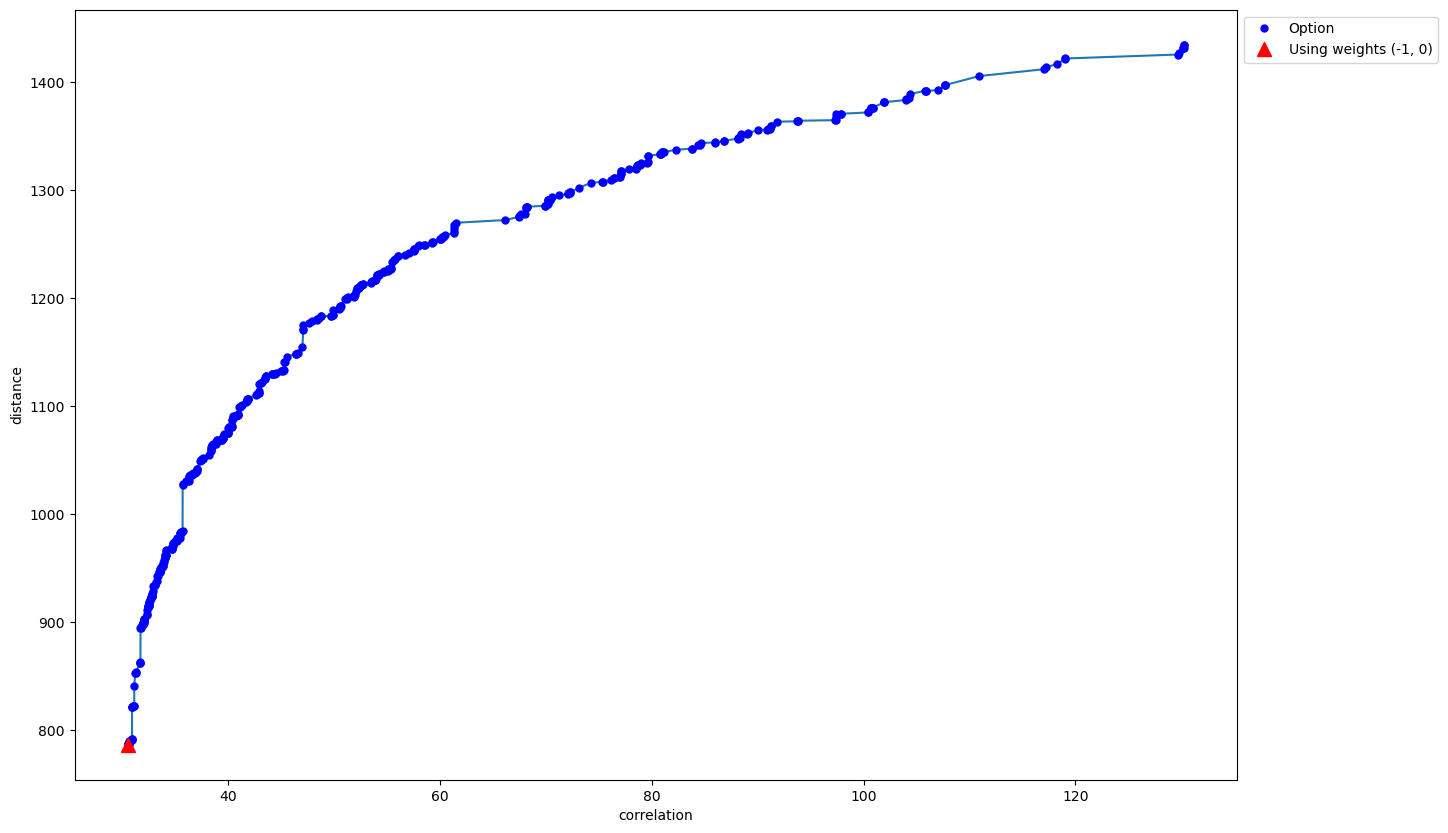

In [9]:
ag.plot(weights=(-1,0))

In [10]:
index = ag.select(index=0)

In [11]:
#filter marker genes in the bulk samples
centroids_sc_pareto = centroids_sc_hv[index]

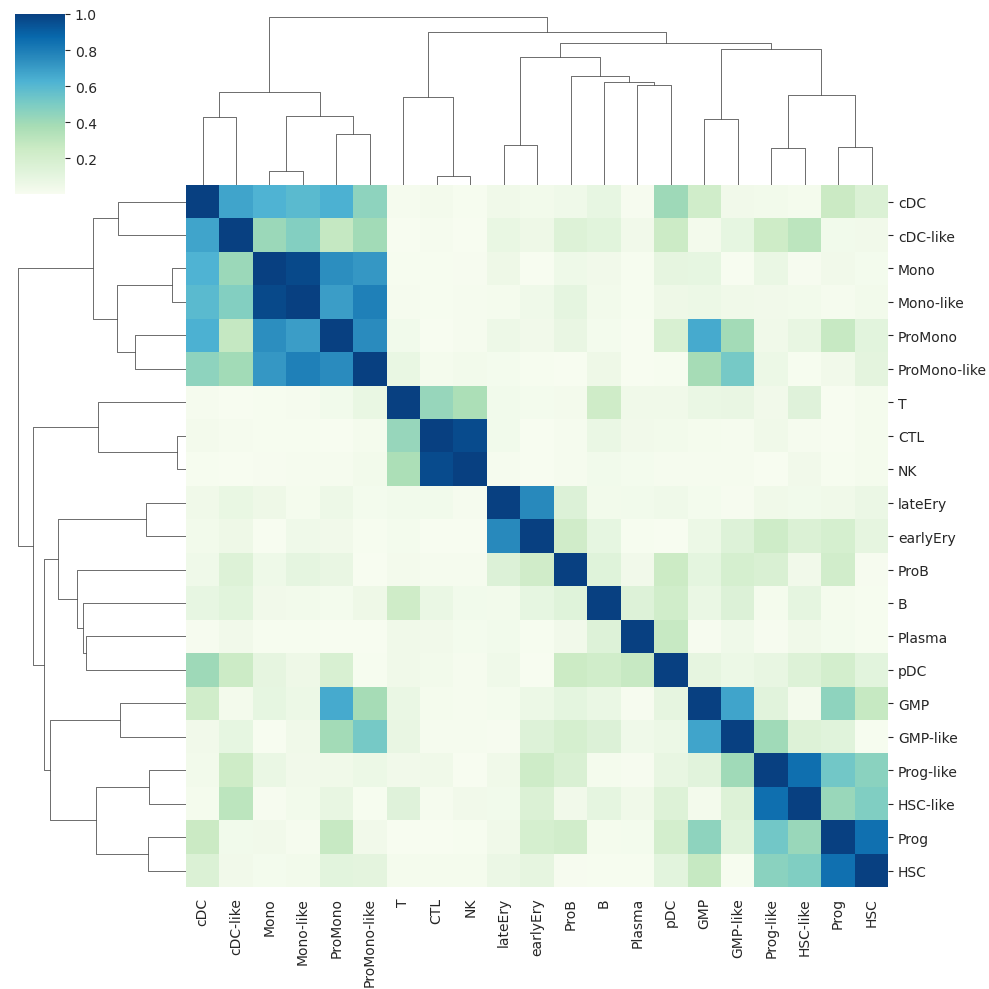

In [12]:
#Correlation matrix
corr = pd.DataFrame(data = np.corrcoef(centroids_sc_pareto.T), columns = centroids_sc_pareto.columns, index = centroids_sc_pareto.columns)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot =sns.clustermap(np.abs(corr),cmap=sns.color_palette("GnBu", 1000), robust=True)

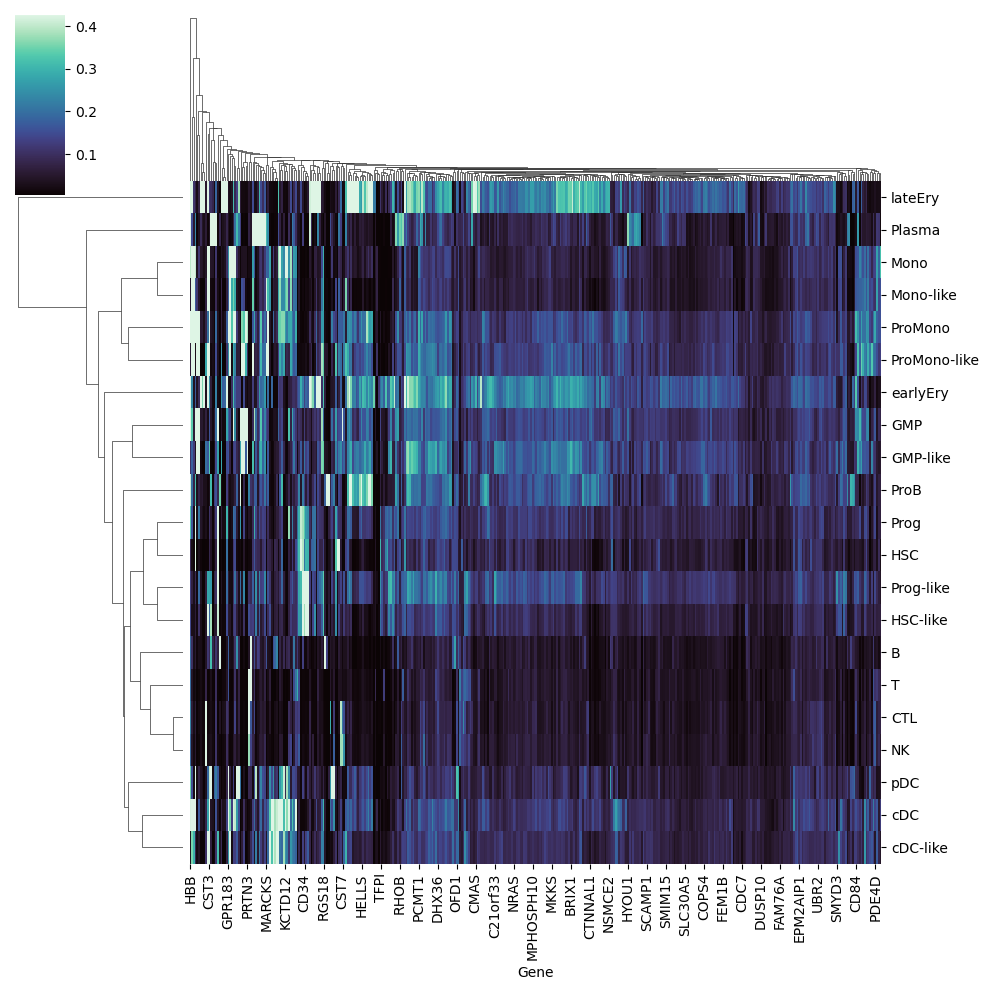

In [13]:
#marker genes
import seaborn as sns
subTypes = pd.DataFrame
subTypes = centroids_sc_pareto.columns
type_pal = sns.husl_palette(centroids_sc_pareto.columns.size, s=0.7)
lut = dict(zip(centroids_sc_pareto.columns.unique(), type_pal))
row_colors = subTypes.map(lut)
sns_plot = sns.clustermap(centroids_sc_pareto.T, cmap="mako", robust=True)

## Regression

In [14]:
coef_nusvr = ag.deconvolve(data_bulk_raw.T, model='nusvr')
coef_nnls = ag.deconvolve(data_bulk_raw.T, model='nnls')

In [15]:
def normalize_proportions(data,copy):
    if copy==True:
        data_copy = data.copy()
    else:
        data_copy = data
    data_copy[data_copy < 0] = 0
    for raw in data_copy.index:
        sum = data_copy.loc[raw].sum()
        data_copy.loc[raw] = np.divide(data_copy.loc[raw],sum)
    return data_copy

In [16]:
proportions_NuSVR = normalize_proportions(pd.DataFrame(data=coef_nusvr,columns=clusters,index=data_bulk_raw.columns), copy = False)
proportions_nnls = normalize_proportions(pd.DataFrame(data=coef_nnls,columns=clusters,index=data_bulk_raw.columns), copy = False)

In [17]:
proportions_NuSVR.to_csv("proportions_NuSVR.tsv", sep='\t')
proportions_nnls.to_csv("proportions_nnls.tsv", sep='\t')

# Compare Proportions Across Groups

In [21]:
path = './bulks/'
cellAnnot = pd.read_csv(path + 'cellAnnot_signatures.csv', index_col=0)
nusvr = proportions_NuSVR

In [22]:
# Group df
nusvr['signature'] = 'Intermediate'
samples = cellAnnot[cellAnnot["signature"]=="Prenatal"].index
nusvr.loc[samples, 'signature'] = 'Inferred-Prenatal'

samples = cellAnnot[cellAnnot["signature"]=="Postnatal"].index
nusvr.loc[samples, 'signature'] = 'Inferred-Postnatal'

nusvr = nusvr[nusvr['signature']!='Intermediate']

# Calculate mean and std err for plotting
grouped_nusvr = nusvr.groupby(by=("signature"))

means = grouped_nusvr.mean().T

errors = grouped_nusvr.sem().T


group1 = nusvr[nusvr['signature']=='Inferred-Prenatal']
group2 = nusvr[nusvr['signature']=='Inferred-Postnatal']

celltypes = nusvr.columns.drop('signature')

In [26]:
def pval_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

pvals = {}
for c in celltypes:
    print(c)
    data_group1 = np.array(group1[c])
    data_group2 = np.array(group2[c])
    # Test for equal variance
    levene = stats.levene(data_group1, data_group2, center='mean')
    if levene[1] > 0.05:
        shap1 = stats.shapiro(data_group1)
        shap2 = stats.shapiro(data_group2)
        if shap1[1] > 0.05 and shap2[1] > 0.05:
            t = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
            pvals[c] = [t[1],pval_to_asterisks(t[1]),'eqv_nd']
        else:
            t = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
            pvals[c] = [t[1],pval_to_asterisks(t[1]),'eqv_nnd']
    else:
        shap1 = stats.shapiro(data_group1)
        shap2 = stats.shapiro(data_group2)
        if shap1[1] > 0.05 and shap2[1] > 0.05:
            t = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=False)
            pvals[c] = [t[1],pval_to_asterisks(t[1]),'var_nd']
        else:
            t = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=False)
            pvals[c] = [t[1],pval_to_asterisks(t[1]),'var_nnd']

print(pvals)

Mono
T
lateEry
cDC
GMP
earlyEry
ProB
CTL
ProMono
NK
ProMono-like
Prog
B
Plasma
pDC
Prog-like
cDC-like
Mono-like
HSC
GMP-like
HSC-like
{'Mono': [0.0853303640419223, 'ns', 'eqv_nnd'], 'T': [3.267754316122945e-05, '****', 'var_nnd'], 'lateEry': [0.004148022746182776, '**', 'var_nnd'], 'cDC': [0.02787969434379071, '*', 'eqv_nnd'], 'GMP': [0.1352188845594089, 'ns', 'eqv_nd'], 'earlyEry': [0.5095654627828421, 'ns', 'eqv_nd'], 'ProB': [0.34004327703239134, 'ns', 'eqv_nnd'], 'CTL': [0.012973335311206664, '*', 'var_nnd'], 'ProMono': [0.08550992761493756, 'ns', 'eqv_nnd'], 'NK': [0.14189828109073954, 'ns', 'eqv_nnd'], 'ProMono-like': [0.008334537433968928, '**', 'eqv_nd'], 'Prog': [0.0006469736182865316, '***', 'eqv_nd'], 'B': [0.03295150825788298, '*', 'var_nnd'], 'Plasma': [0.4139744844756382, 'ns', 'eqv_nnd'], 'pDC': [0.7938200817722709, 'ns', 'eqv_nnd'], 'Prog-like': [0.2108708552479745, 'ns', 'eqv_nd'], 'cDC-like': [0.0005660893980641855, '***', 'var_nnd'], 'Mono-like': [0.03855505024985727

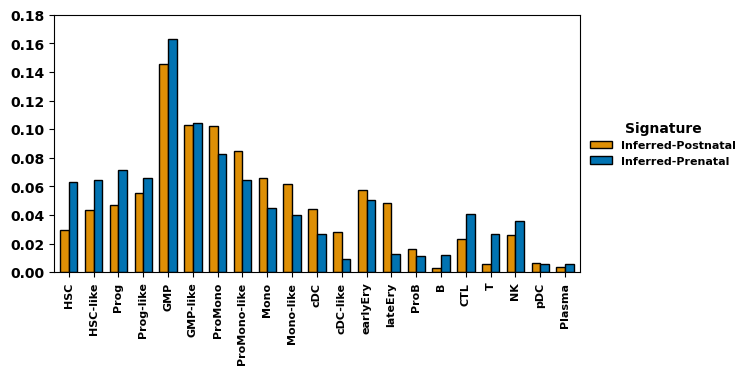

In [28]:
# Plotting
palette_color = {'Inferred-Prenatal':(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
                'Inferred-Postnatal':(0.8705882352941177, 0.5607843137254902, 0.0196078431372549)}
plt.rcParams.update({'font.weight': 'bold'})

row_order = ['HSC','HSC-like','Prog','Prog-like',
             'GMP','GMP-like','ProMono','ProMono-like',
             'Mono','Mono-like','cDC','cDC-like','earlyEry','lateEry','ProB','B','CTL','T',
             'NK','pDC','Plasma']
means = means.loc[row_order,:]

ax = means.plot.bar(rot=90, color=palette_color, width=0.7, edgecolor = "black", figsize=(6,4))
plt.tight_layout()
plt.grid(False)
legend = ax.legend(title="Signature",
                   loc="center left",
                   fontsize=8,
                   frameon=False,
                   bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(legend.get_title(),fontsize=10)
plt.xticks(fontsize=8, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.ylim(0, 0.18)
plt.xlabel('', fontsize=10, fontweight='bold')
plt.savefig("aml_eto_tcga_deconv.png", dpi=500, format='png', bbox_inches='tight', pad_inches=0.5)

In [30]:
!conda list

# packages in environment at /Users/jwhittle/opt/anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py39hca03da5_1  
absl-py                   1.4.0                    pypi_0    pypi
adjusttext                1.2.0                    pypi_0    pypi
aiohttp                   3.8.4                    pypi_0    pypi
aiosignal                 1.3.1                    pypi_0    pypi
alabaster                 0.7.12             pyhd3eb1b0_0  
anaconda                  2022.10                  py39_0  
anaconda-client           1.11.0           py39hca03da5_0  
anaconda-navigator        2.3.1            py39hca03da5_0  
anaconda-project          0.11.1           py39hca03da5_0  
anndata                   0.8.0                    pypi_0    pypi
annoy                     1.17.1                   pypi_0    pypi
anyio                     3.5.0            py39hca03da5_0  
appdirs                   1.4.4              pyhd3eb1b0